<h1>ARIMA Model</h1>
<p>
    Models generated using statmodels. Datasets gathered from <a href = "https://www.coindesk.com/">CoinDesk.</a>
    <br/> <br/>
    Autoregressive integrated moving average - ARIMA - is a time series model that predicts future value(s) derived from <i><b>past</b></i> vaules.
    <br/>
    To build a ARIMA mode, we must specify three variables AR order term (p), differencing order term (d), and MA order term (q); where p and q is the amout of lag that will take into consideration when predicting a future value in an AR and MA model, respectively, and d is the number of differencing needed to make the time series data stationary.
</p>

In [111]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

import math as ma
import datetime as dt
import warnings
from IPython import get_ipython

warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

get_ipython().run_line_magic('matplotlib', 'inline')

In [112]:
def get_csv(path: str) -> pd.DataFrame:
    
    df = pd.read_csv(path, parse_dates = ['Date'])\
        .drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])\
        .rename(columns = {'Date': 'date', 'Closing Price (USD)': 'price'})\
        .set_index('date')\
        .asfreq(freq = '1d', method = 'pad')

    return df

In [113]:
df_eth  = get_csv('./data/Ethereum.csv')
df_ada  = get_csv('./data/Cardano.csv')
df_doge = get_csv('./data/Dogecoin.csv')
df_sol  = get_csv('./data/Solana.csv')

<h3>Augmented Dickey Fuller Test (ADF Test)</h3>
<p>p-value should be << 0.05</p>

In [85]:
result = adfuller(df_ada.diff().dropna())

print(f'p-value: {result[1]}')

p-value: 2.0694026249646475e-30


<h2>ADA Coin</h2>

<h3>Stationary test</h3>
<p>
    For time series analysis to work well, the time series data should be stationary. We can gauge it by ploting the ACF (Autocorrelation function) which asserts how much does a lag of a certain value affect said value, the autocorrelation value ranges from 1 to -1, a lag with autocorrelation value of 1 is said to affect the current value by 100%.
</p>

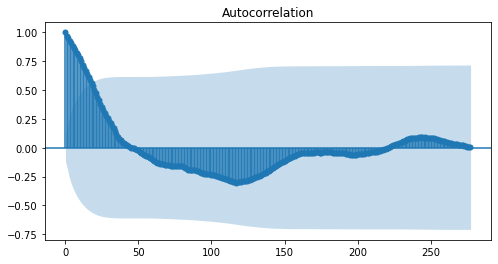

In [86]:
fig, axis = plt.subplots(1, 1, figsize = (8, 4))
plot_acf(df_ada, lags = len(df_ada.index) - 1, ax = axis)
plt.show()

<p>
    When we ploted the ACF for ada dataset a sin-like graph appear. This indicates that the data is not stationary; thus, a differencing is needed.
</p>

----
<h3>1st Order Differencing</h3>
<p>
    Differencing is done by subtracting the first lag of a value.
</p>

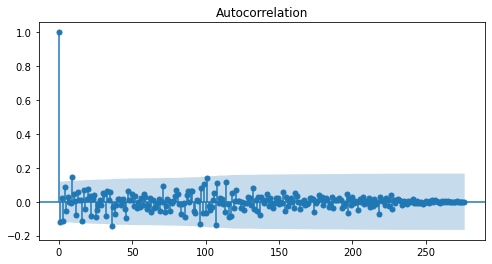

In [87]:
fig, axis = plt.subplots(1, 1, figsize = (8, 4))
plot_acf(df_ada.diff().dropna(), lags = len(df_ada.index) - 2, ax = axis)
plt.show()

d = 1

<p>
    With the 1st order differencings, we can observe that the ACF plot no longer exhibits the sin-like pattern: the dataset is now stationary.
    <br/>
    Thus, the d variable should be 1.
</p>

----
<h3>Finding p and q.</h3>
<p>
    To find the AR order (p) and MA order (q), we can plot the ACF and PACF of the time series. We can use the ACF to find q, and the PACF to find p.
</p>

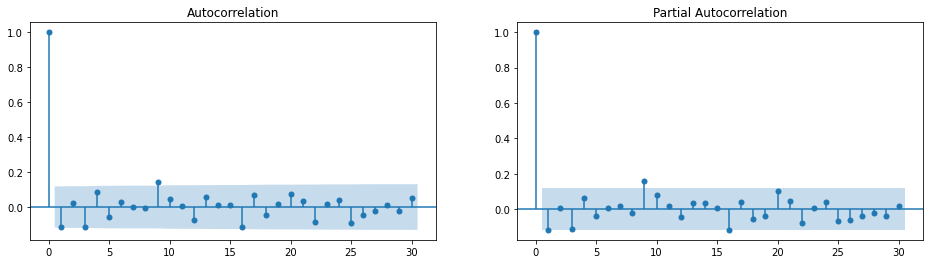

In [88]:
fig, axes = plt.subplots(1, 2, sharex = 'all', figsize = (16, 4))
plot_acf(df_ada.diff().dropna(), lags = 30, ax = axes[0])
plot_pacf(df_ada.diff().dropna(), lags = 30, ax = axes[1])
plt.show()

<p>
    Interestingly, no lag shows significance level of correlation on both ACF and PACF plot, meaning that using time series analysis on this dataset would not yield a useful result.
    <br/>
    We can see how useful time series analysis on this dataset is by using rolling forecast.
</p>

----
<h3>Rolling Forecast</h3>
<p>
    Rolling forecast is the method for evaluating time series models. It generates a new model every time the time frame moves, it is useful for evaluating time series models since the model gets more inaccurate overtime, rolling forecast creates a model that predict the next value and then move on the next time frame and generate a new model, it does this repetitively until the last time frame.
</p>

In [89]:
def rolling_forecast(df: pd.DataFrame, order = (1, 1, 1), test_ratio: float = 0.3) -> pd.DataFrame:

    prediction_roll = pd.Series(dtype = 'float64')

    test_data = df[ma.floor(len(df.index) * (1 - test_ratio)) + 1:]

    for end_date in test_data.index:

        train_data = df[:end_date - dt.timedelta(days = 1)]
        model = ARIMA(train_data, order = order)
        model_fit = model.fit(method_kwargs = {"warn_convergence": False, "warn_": False})
        pred = model_fit.predict(end_date)
        prediction_roll.loc[end_date] = pred.loc[end_date]

    return pd.DataFrame({'pred': prediction_roll, 'real': test_data['price']})

<p>
    If we went ahead and try to create an ARIMA model it wil look something like this. 
</p>

In [90]:
ada_rolling = rolling_forecast(df_ada, (1,1,1))

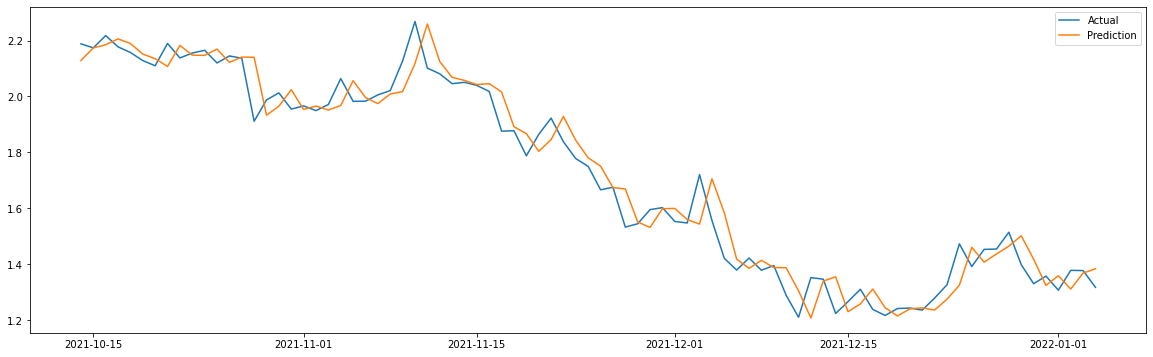

In [91]:
plt.figure(figsize=(20,6))
plt.plot(ada_rolling['real'], label = 'Actual')
plt.plot(ada_rolling['pred'], label = 'Prediction')
plt.legend(loc = 'best')
plt.show()

As you can see, the model prediction is, at best, lagging; at worst, it is unusable.

---

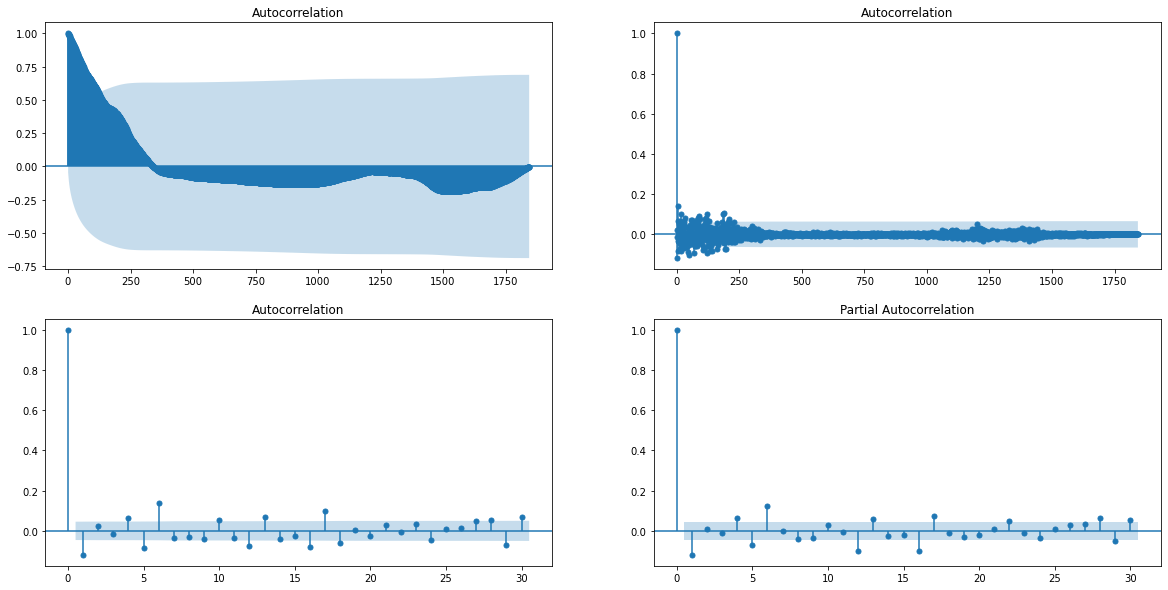

In [92]:
fig, axes = plt.subplots(2, 2, sharex = 'none', figsize = (20, 10))
plot_acf(df_eth, lags = len(df_eth) - 1, ax = axes[0, 0])
plot_acf(df_eth.diff().dropna(), lags = len(df_eth) - 2, ax = axes[0, 1])
plot_acf(df_eth.diff().dropna(), lags = 30, ax = axes[1, 0])
plot_pacf(df_eth.diff().dropna(), lags = 30, ax = axes[1, 1])
plt.show()

In [ ]:
eth_rolling = rolling_forecast(df_eth, (6,1,6))

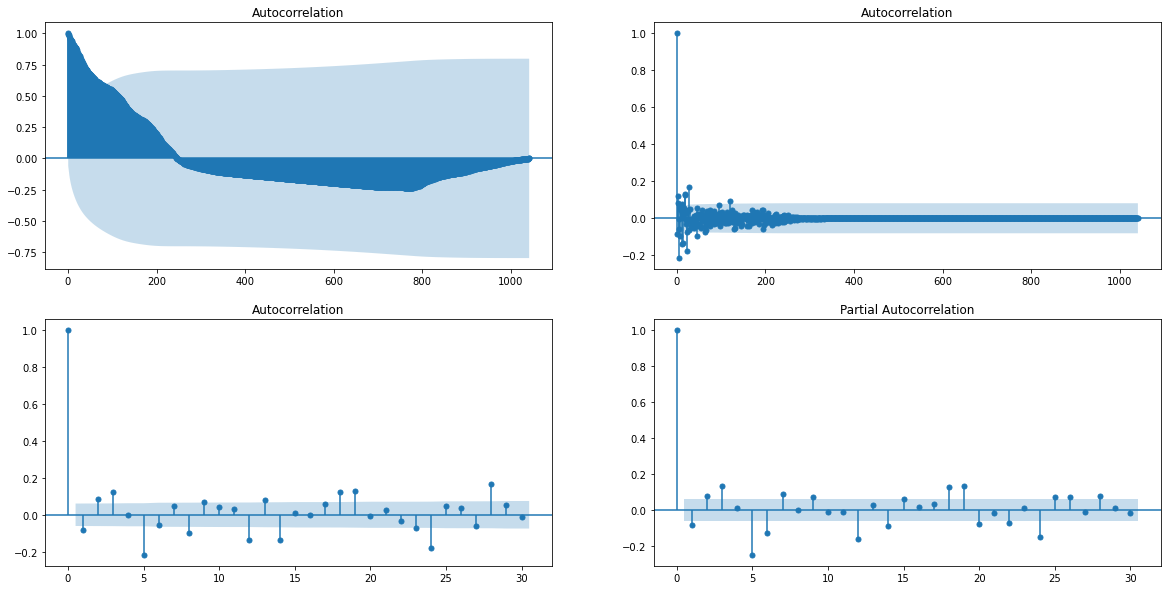

In [150]:
fig, axes = plt.subplots(2, 1, sharex = 'none', figsize = (20, 12))
residuals = eth_rolling['real'] - eth_rolling['pred']
axes[0].plot(eth_rolling['real'], label  = 'Real')
axes[0].plot(eth_rolling['pred'], label = 'Predicted')
axes[0].set_title('Real vs Predicted')
axes[1].plot(residuals)
axes[1].set_title('Residuals')
plt.show()

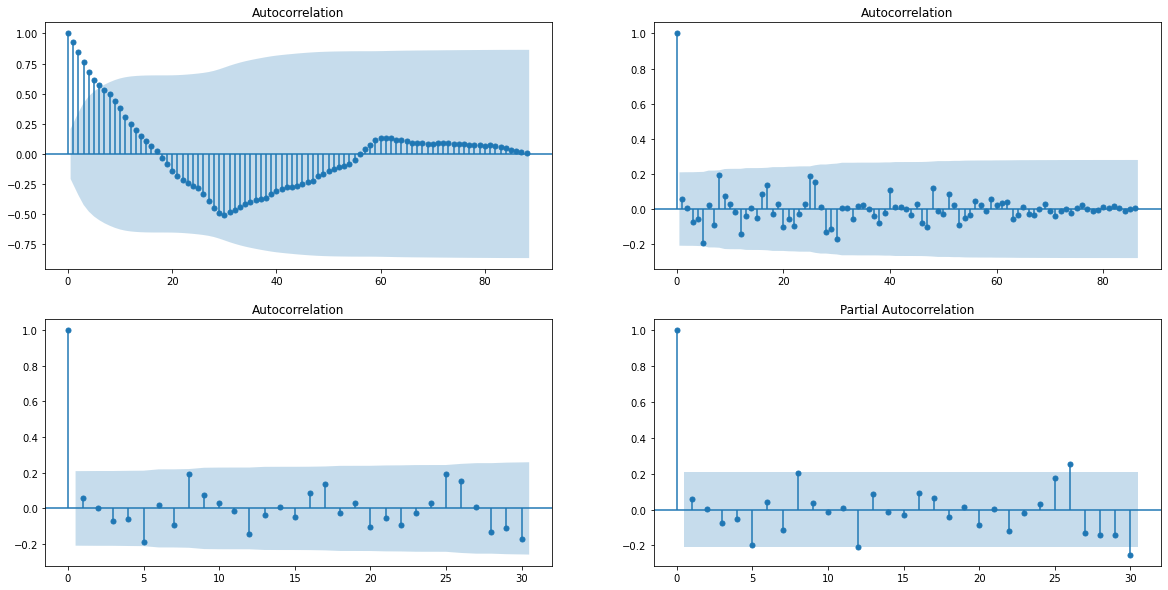

In [95]:
fig, axes = plt.subplots(2, 2, sharex = 'none', figsize = (20, 10))
plot_acf(df_sol, lags= len(df_sol) - 1, ax = axes[0, 0])
plot_acf(df_sol.diff().dropna(),lags= len(df_sol.diff().dropna()) - 2, ax = axes[0, 1])
plot_acf(df_sol.diff().dropna(), lags = 30, ax = axes[1, 0])
plot_pacf(df_sol.diff().dropna(), lags = 30, ax = axes[1, 1])
plt.show()

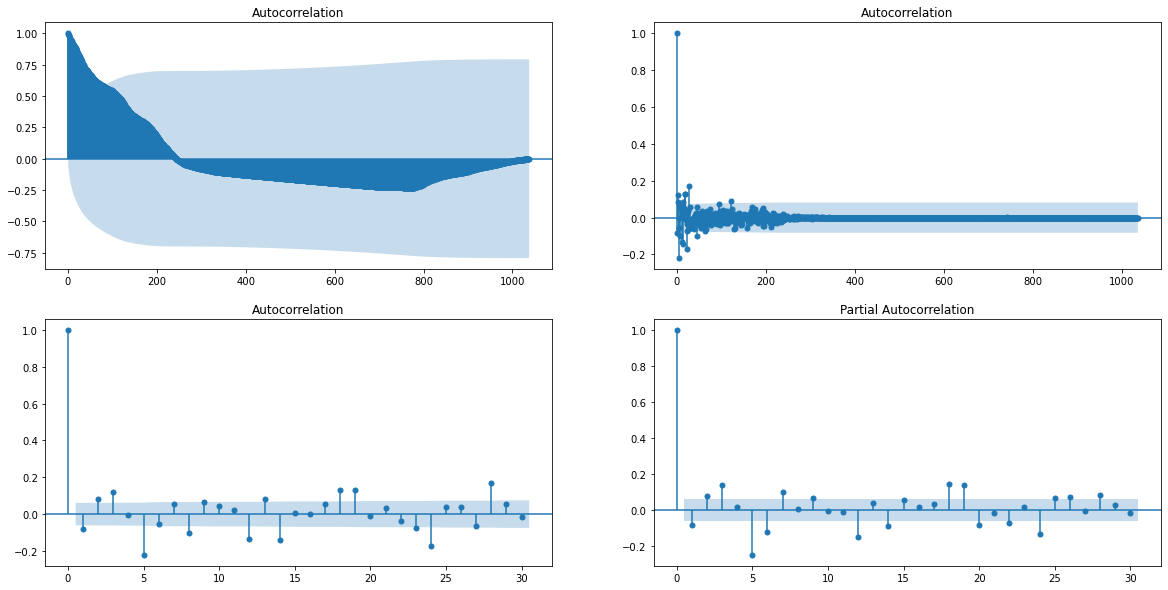

In [96]:
fig, axes = plt.subplots(2, 2, sharex = 'none', figsize = (20, 10))
plot_acf(df_doge, lags = len(df_doge) - 1, ax = axes[0, 0])
plot_acf(df_doge.diff().dropna(), lags = len(df_doge) - 2, ax = axes[0, 1])
plot_acf(df_doge.diff().dropna(), lags = 30, ax = axes[1, 0])
plot_pacf(df_doge.diff().dropna(), lags = 30, ax = axes[1, 1])
plt.show()

In [142]:
doge_rolling = rolling_forecast(df_doge.drop(pd.date_range(start = df_doge.index[0], end = '2021-01-01', freq = '1d')), (5,1,5))

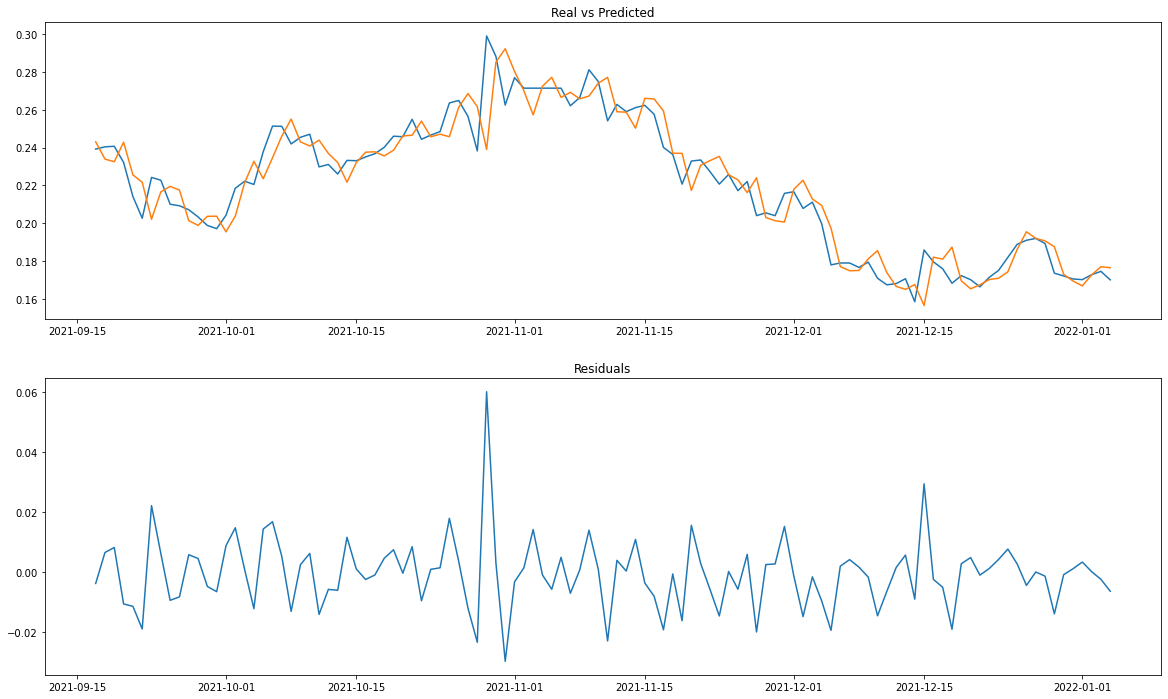

In [143]:
fig, axes = plt.subplots(2, 1, sharex = 'none', figsize = (20, 12))
doge_residuals = doge_rolling['real'] - doge_rolling['pred']
axes[0].plot(doge_rolling['real'], label  = 'Real')
axes[0].plot(doge_rolling['pred'], label = 'Predicted')
axes[0].set_title('Real vs Predicted')
axes[1].plot(doge_residuals)
axes[1].set_title('Residuals')
plt.show()